In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import multigrate as mtg
from matplotlib import pyplot as plt

# Load the dataset

In [2]:
scrna = sc.read('../data/10xpbmc10k-2020/expressions_hvg.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [3]:
atac = sc.read('../data/10xpbmc10k-2020/peaks.h5ad')
atac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary'

In [34]:
model = mtg.models.MultiVAE_PoE_small(
    adatas=[[scrna], [atac]],
    names=[['rna1'], ['atac1']],
    pair_groups=[['pair1'], ['pair1']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'bce'],
    layers=[['count'], ['binary']],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2
)

In [35]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 0.9125, -0.8766,  0.8539, -1.6313, -0.0033,  0.5204, -0.1413,  1.6188,
          0.5673, -0.3567, -0.4378,  1.1799,  0.3731, -1.7833, -0.5918],
        [ 0.5385,  1.1037, -1.5606, -0.5043, -0.9260, -0.0348,  0.3460, -0.5674,
          2.0247, -0.8975, -0.1058, -0.2456,  0.0331,  0.1377,  0.5343]],
       device='cuda:0', requires_grad=True)

In [36]:
model.train(
    n_iters=5000,
    #celltype_key='celltype.l1',
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=2500,
    validate_every=500,
    correct='all', #missing, none, all
    kernel_type='gaussian',
    version='2'
)

 |████████████████████| 100.0% iter=5000/5000, time=15.10(s), loss=0.6568, recon=0.6557, kl=108.1966, integ=0.0000, cycle=0.0000, val_loss=0.6606, val_recon=0.6596, val_kl=96.0860, val_integ=0.0000, val_cycle=0.0000

In [37]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 1.2629, -1.2026,  1.1600, -1.7134, -0.3398,  0.8393, -0.4116,  1.8185,
          0.9589, -0.6541, -0.7178,  1.5168,  0.3926, -1.9652, -0.8347],
        [ 0.8554,  1.2686, -1.7934, -0.8499, -1.2507,  0.3780,  0.4739, -0.8198,
          2.2724, -1.2784, -0.4129, -0.0622, -0.3152,  0.4203,  0.6758]],
       device='cuda:0', requires_grad=True)

In [38]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,mod_vec0_norm,cos_similarity_mod_vectors_0_1,mod_vec1_norm,val_loss,val_recon,val_recon_nb,val_recon_bce,val_kl,val_integ,val_cycle
0,500,0.970234,0.970176,0.0,0.518688,0.0,0.451487,39.523266,0.0,0.0,3.945897,-0.016801,3.576866,0.757361,0.757240,0.400780,0.356460,60.558651,0,0
1,1000,0.735770,0.735524,0.0,0.390815,0.0,0.344709,76.615839,0.0,0.0,4.046533,-0.016801,3.644839,0.717056,0.716765,0.373608,0.343157,72.835846,0,0
2,1500,0.700100,0.699673,0.0,0.356465,0.0,0.343208,81.729298,0.0,0.0,4.116304,-0.016801,3.700612,0.693968,0.693487,0.360237,0.333251,80.082161,0,0
3,2000,0.702008,0.701350,0.0,0.370834,0.0,0.330516,90.959276,0.0,0.0,4.176913,-0.016801,3.743359,0.685297,0.684605,0.355606,0.328999,86.478363,0,0
4,2500,0.691825,0.690938,0.0,0.360170,0.0,0.330768,96.401363,0.0,0.0,4.237636,-0.016801,3.789101,0.679977,0.679064,0.352140,0.326924,91.313866,0,0
5,3000,0.676991,0.676009,0.0,0.357277,0.0,0.318731,98.172147,0.0,0.0,4.301896,-0.016801,3.843495,0.674242,0.673332,0.348660,0.324673,90.942429,0,0
6,3500,0.676184,0.675192,0.0,0.348670,0.0,0.326522,99.214122,0.0,0.0,4.359744,-0.016801,3.901080,0.668603,0.667668,0.345285,0.322383,93.461800,0,0
7,4000,0.669209,0.668167,0.0,0.347878,0.0,0.320289,104.245227,0.0,0.0,4.415288,-0.016801,3.964975,0.664015,0.663035,0.342812,0.320222,98.073967,0,0
8,4500,0.663891,0.662827,0.0,0.344926,0.0,0.317901,106.425737,0.0,0.0,4.469265,-0.016801,4.023152,0.660771,0.659770,0.341063,0.318707,100.165169,0,0
9,4999,0.656775,0.655693,0.0,0.334934,0.0,0.320758,108.196632,0.0,0.0,4.527100,-0.016801,4.072881,0.660565,0.659604,0.339878,0.319726,96.086006,0,0


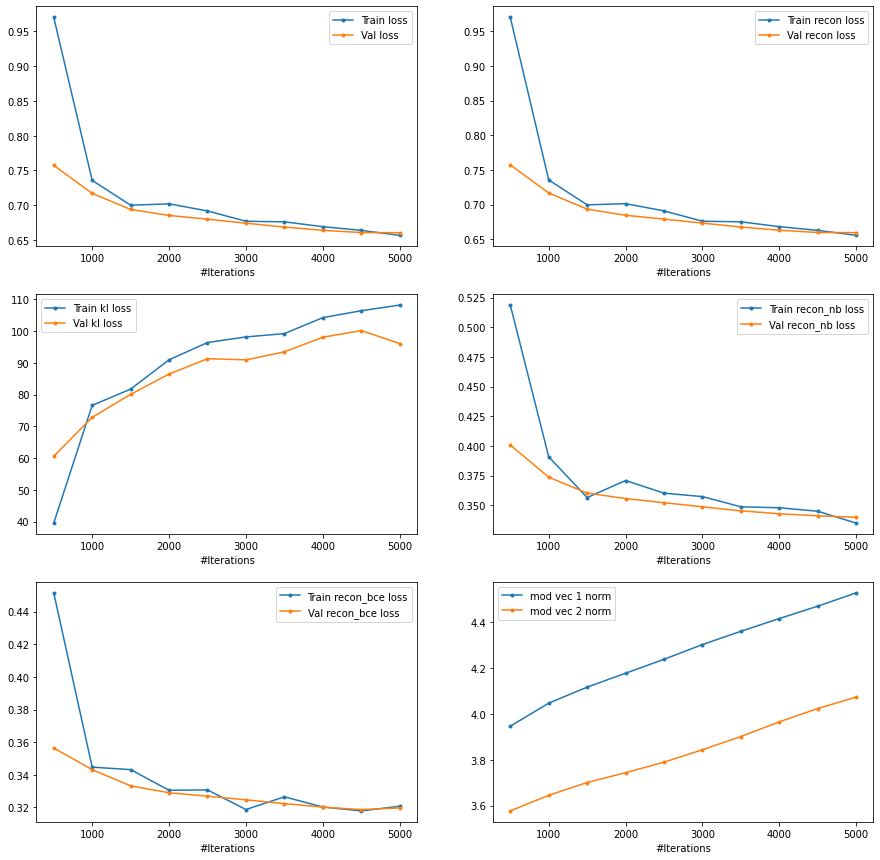

In [69]:
loss_names = ['recon', 'kl']
# if batches also plot integration loss
for n in model.n_batch_labels:
    if n > 1:
        loss_names.append('integ')
for loss in model.losses:
    loss_names.append('recon_' + str(loss))
nrows = int(np.ceil((len(loss_names)+2)/2))

plt.figure(figsize=(15, nrows*5))

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations')
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations')
    plt.legend()

plt.subplot(nrows, 2, nrows*2)
for i in range(model.model.modality_vectors.weight.shape[0]):
    name = 'mod_vec' + str(i) + '_norm'
    label = 'mod vec ' + str(i+1) + ' norm'
    plt.plot(model.history['iteration'], model.history[name], '.-', label=label);
plt.xlabel('#Iterations')
plt.legend()

#plt.savefig(os.path.join(output_dir, f'losses.png'), dpi=80, bbox_inches='tight')
#plt.close('all')

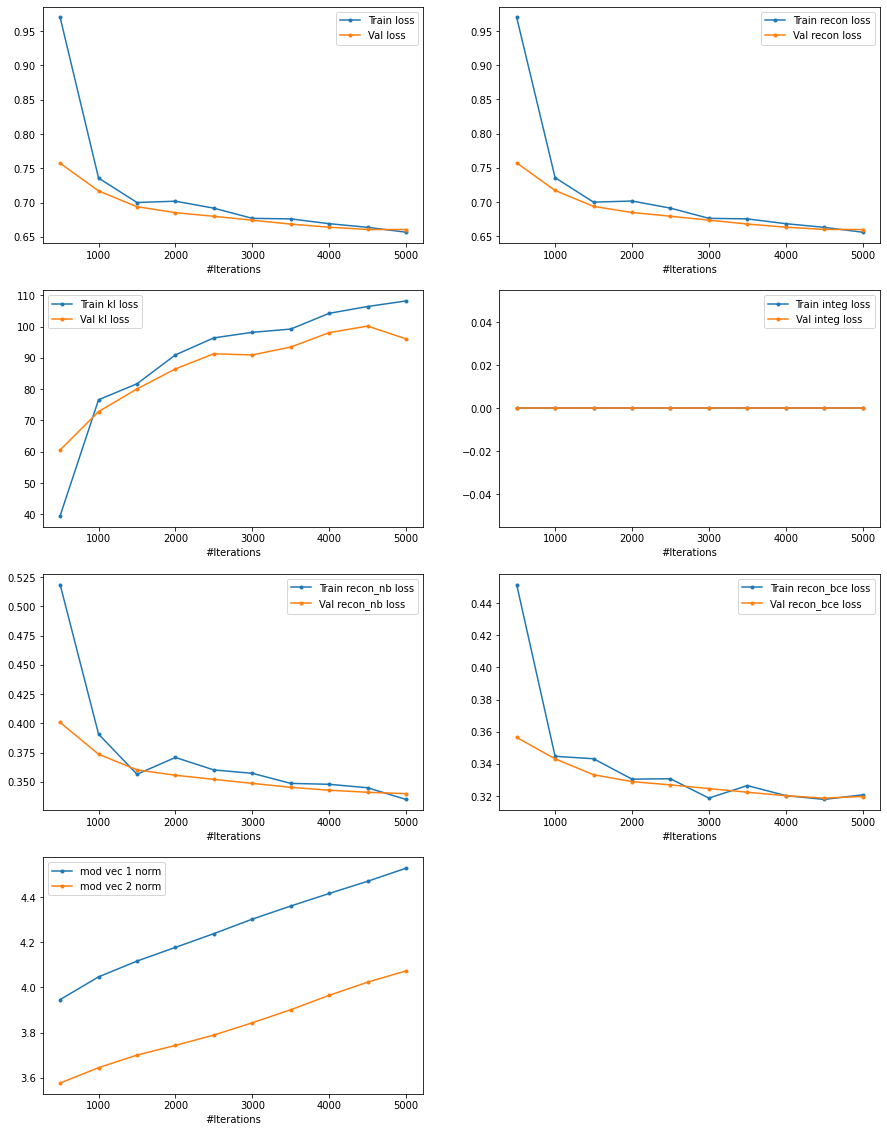

In [39]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_nb', 'recon_bce'] # recon_mse
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

plt.subplot(nrows, 2, nrows*2 - 1)
plt.plot(model.history['iteration'], model.history['mod_vec0_norm'], '.-', label='mod vec 1 norm');
plt.plot(model.history['iteration'], model.history['mod_vec1_norm'], '.-', label='mod vec 2 norm');
#plt.plot(model.history['iteration'], model.history['mod_vec2_norm'], '.-', label='mod vec 3 norm');
plt.xlabel('#Iterations');
plt.legend()

# Validation

In [40]:
out = model.test(
    adatas=[[scrna], [atac]],
    names=[['rna1'], ['atac1']],
    pair_groups=[['pair1'], ['pair1']],
    layers=[['count'], ['binary']],
    batch_size=64,
)

In [41]:
integrated, latent, _, hs = out

In [42]:
latent

AnnData object with n_obs × n_vars = 20000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [43]:
hs

AnnData object with n_obs × n_vars = 20000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [44]:
integrated

AnnData object with n_obs × n_vars = 10000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [45]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [46]:
sc.pp.neighbors(hs)
sc.tl.umap(hs)

In [47]:
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

... storing 'barcode' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


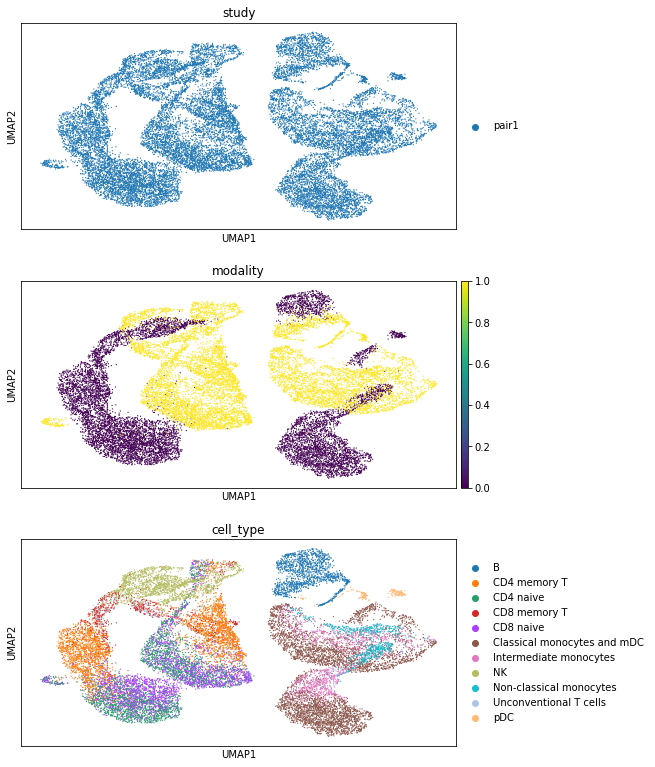

In [48]:
sc.pl.umap(hs, color=['study', 'modality', 'cell_type'], ncols=1, wspace=0.4)

... storing 'barcode' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


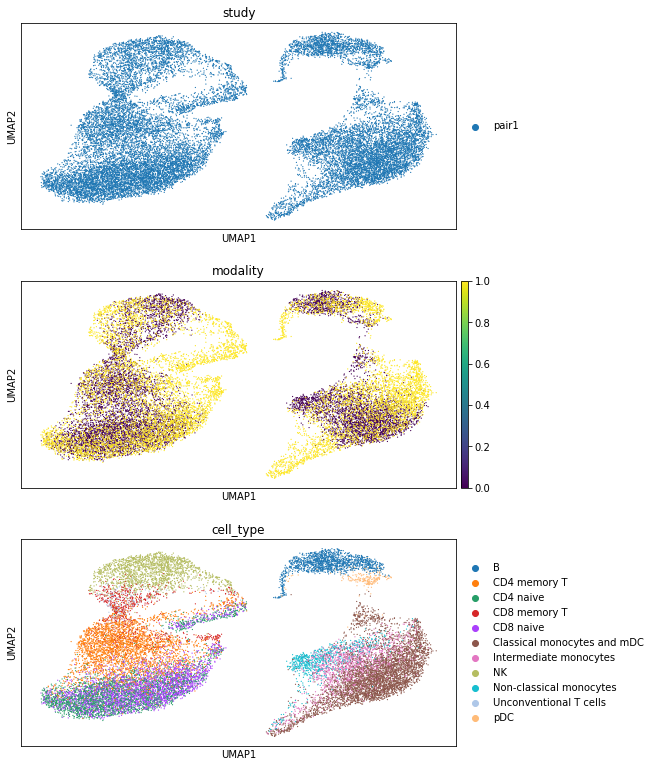

In [49]:
sc.pl.umap(latent, color=['study', 'modality', 'cell_type'], ncols=1, wspace=0.4)

... storing 'modality' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


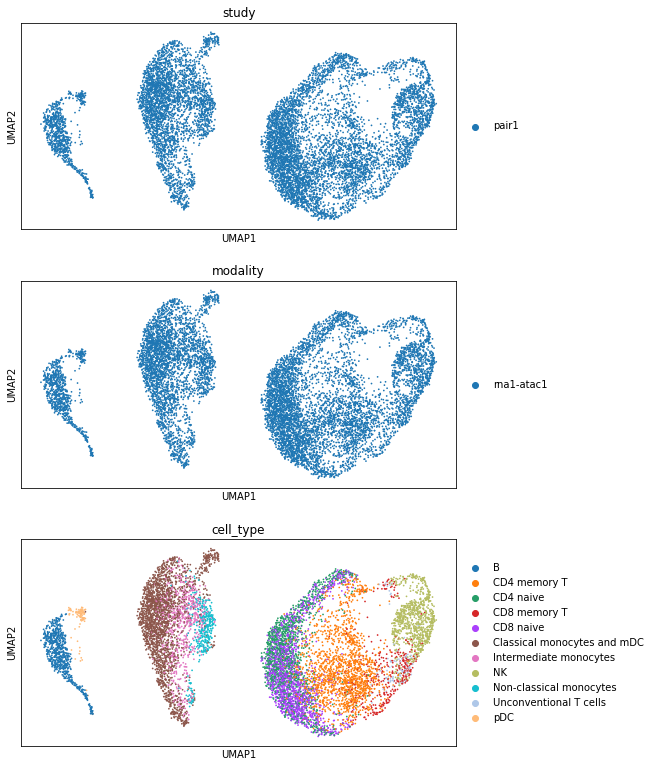

In [50]:
sc.pl.umap(integrated, color=['study', 'modality', 'cell_type'], ncols=1, wspace=0.4)

# old

In [4]:
# renames duplicate protein names from CD3-1, CD3-2 to CD3 and CD3-1; need for concatentation
cite.var_names = [name.split('-')[0] for name in cite.var_names]
cite.var_names_make_unique()

In [5]:
# take one batch
scrna = scrna[scrna.obs.Batch=='Batch1']
cite = cite[cite.obs.Batch=='Batch1']

In [6]:
scrna2 = sc.read('../data/sanger-2021/expressions-2.h5ad')
scrna2

AnnData object with n_obs × n_vars = 3475 × 23305
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [7]:
atac = sc.read('../data/sanger-2021/peaks_hvf-2.h5ad')
atac

AnnData object with n_obs × n_vars = 3475 × 40122
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'binary'

In [8]:
scrna3 = sc.read('../data/kotliarov-2020/expressions.h5ad')
scrna3

AnnData object with n_obs × n_vars = 52117 × 20245
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [9]:
cite3 = sc.read('../data/kotliarov-2020/protein.h5ad')
cite3

AnnData object with n_obs × n_vars = 52117 × 87
    obs: 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [10]:
# take one batch
scrna3 = scrna3[scrna3.obs.batch==2]
cite3 = cite3[cite3.obs.batch==2]

# Prep RNA-seq

In [11]:
len(set(scrna.var_names) & set(scrna2.var_names) & set(scrna3.var_names))

14234

In [12]:
common_genes = list(set(scrna.var_names) & set(scrna2.var_names) & set(scrna3.var_names))

In [13]:
scrna = scrna[:, common_genes]
scrna2 = scrna2[:, common_genes]
scrna3 = scrna3[:, common_genes]

In [14]:
adata = scrna.concatenate(scrna2, scrna3)
adata

AnnData object with n_obs × n_vars = 92196 × 14234
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2

In [15]:
adata.X = adata.layers['count']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [17]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 92196 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_c

In [18]:
adata1 = adata[adata.obs.batch == '0']
adata2 = adata[adata.obs.batch == '1']
adata3 = adata[adata.obs.batch == '2']

In [19]:
adata1.obs['cell_type'] = adata1.obs['celltype.l1']
cite.obs['cell_type'] = cite.obs['celltype.l1']

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [20]:
adata1.obs['celltype.l2'].astype('category').cat.categories

Index(['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD14 Mono',
       'CD16 Mono', 'CD4 CTL', 'CD4 Naive', 'CD4 Proliferating', 'CD4 TCM',
       'CD4 TEM', 'CD8 Naive', 'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM',
       'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating',
       'NK_CD56bright', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2',
       'dnT', 'gdT', 'pDC'],
      dtype='object')

# Prep ADT

In [21]:
cite3.var_names = [name.split('_')[0] for name in cite3.var_names]

In [22]:
common_protein = list(set(cite.var_names) & set(cite3.var_names))
len(common_protein)

66

In [23]:
cite = cite[:, common_protein]
cite3 = cite3[:, common_protein]

In [24]:
adata = cite.concatenate(cite3)
adata

AnnData object with n_obs × n_vars = 88721 × 66
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'n_cells-0', 'n_cells-1'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'

In [25]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [26]:
adata.X = adata.layers['count']
adata = clr_normalize_each_cell(adata)

In [27]:
cite1 = adata[adata.obs.batch == '0']
cite3 = adata[adata.obs.batch == '1']

# Rename cell types

In [28]:
adata1.obs.cell_type = adata1.obs.cell_type.astype('category')
adata2.obs.cell_type = adata2.obs.cell_type.astype('category')
adata3.obs.cell_type = adata3.obs.cell_type.astype('category')
cite.obs.cell_type = cite.obs.cell_type.astype('category')
cite3.obs.cell_type = cite3.obs.cell_type.astype('category')
atac.obs.cell_type = atac.obs.cell_type.astype('category')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [29]:
adata1.obs.cell_type.cat.categories

Index(['B', 'CD4 T', 'CD8 T', 'DC', 'Mono', 'NK', 'other', 'other T'], dtype='object')

In [30]:
adata2.obs.cell_type.cat.categories

Index(['Bcell Memory', 'Bcell Naive', 'CD14 IL1B Monocyte', 'CD14 Monocyte',
       'CD16 Monocyte', 'CD4', 'CD4 Naive', 'CD8 Effector', 'CD8 Naive',
       'Cycling', 'GD Tcell', 'ILC', 'MAIT', 'NK', 'Plasmablasts', 'Treg',
       'cDC', 'pDC'],
      dtype='object')

In [31]:
adata3.obs.cell_type.cat.categories

Index(['B', 'CD4 memory T', 'CD4 naive', 'CD8 memory T', 'CD8 naive',
       'Classical monocytes and mDC', 'NK', 'Non-classical monocytes',
       'Unconventional T cells', 'pDC'],
      dtype='object')

In [34]:
new_adata2_cat = {
    'Bcell Memory': 'B', 
    'Bcell Naive': 'B', 
    'CD14 IL1B Monocyte': 'Mono', 
    'CD14 Monocyte': 'Mono',
    'CD16 Monocyte': 'Mono', 
    'CD4': 'CD4 T memory', 
    'CD4 Naive': 'CD4 T naive', 
    'CD8 Effector': 'CD8 T memory', 
    'CD8 Naive': 'CD8 T naive',
    'Cycling': 'other', 
    'GD Tcell': 'other T', 
    'ILC': 'other', 
    'MAIT': 'other T', 
    'NK': 'NK', 
    'Plasmablasts': 'other', 
    'Treg': 'other T',
    'cDC': 'DC',
    'pDC': 'DC'
}

In [35]:
new_adata3_cat = {
    'B': 'B', 
    'CD4 memory T': 'CD4 T memory',
    'CD4 naive': 'CD4 T naive',
    'CD8 memory T': 'CD8 T memory',
    'CD8 naive': 'CD8 T naive',
    'Classical monocytes and mDC': 'Mono', 
    'NK': 'NK', 
    'Non-classical monocytes': 'Mono',
    'Unconventional T cells': 'other T', 
    'pDC': 'DC'
}

In [36]:
new_cell_types_2 = [new_adata2_cat[name] for name in adata2.obs.cell_type]
new_cell_types_3 = [new_adata3_cat[name] for name in adata3.obs.cell_type]

In [37]:
adata2.obs['old_cell_type'] = adata2.obs['cell_type']
adata2.obs['cell_type'] = new_cell_types_2
adata2.obs['cell_type'] = adata2.obs['cell_type'].astype('category')
adata2.obs['cell_type'].cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other', 'other T'],
      dtype='object')

In [38]:
adata3.obs['old_cell_type'] = adata3.obs['cell_type']
adata3.obs['cell_type'] = new_cell_types_3
adata3.obs['cell_type'] = adata3.obs['cell_type'].astype('category')
adata3.obs['cell_type'].cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other T'],
      dtype='object')

In [39]:
atac.obs['old_cell_type'] = atac.obs['cell_type']
atac.obs['cell_type'] = new_cell_types_2
atac.obs['cell_type'] = atac.obs['cell_type'].astype('category')
atac.obs['cell_type'].cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other', 'other T'],
      dtype='object')

In [40]:
cite3.obs['old_cell_type'] = cite3.obs['cell_type']
cite3.obs['cell_type'] = new_cell_types_3
cite3.obs['cell_type'] = cite3.obs['cell_type'].astype('category')
cite3.obs['cell_type'].cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other T'],
      dtype='object')

In [45]:
adata1.obs['celltype.l2'].astype('category').cat.categories

Index(['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD14 Mono',
       'CD16 Mono', 'CD4 CTL', 'CD4 Naive', 'CD4 Proliferating', 'CD4 TCM',
       'CD4 TEM', 'CD8 Naive', 'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM',
       'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating',
       'NK_CD56bright', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2',
       'dnT', 'gdT', 'pDC'],
      dtype='object')

In [63]:
new_cell_types_1 = []
for i, cell in enumerate(adata1.obs['celltype.l2']):
    if cell in ['CD4 CTL', 'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM']:
        new_cell_types_1.append('CD4 T memory')
    elif cell == 'CD4 Naive':
        new_cell_types_1.append('CD4 T naive')
    elif cell in ['CD8 Proliferating', 'CD8 TCM', 'CD8 TEM']:
        new_cell_types_1.append('CD8 T memory')
    elif cell == 'CD8 Naive':
        new_cell_types_1.append('CD8 T naive')
    elif cell == 'Treg':
        new_cell_types_1.append('other T')
    else:
        new_cell_types_1.append(adata1.obs['celltype.l1'][i])

In [64]:
adata1.obs['cell_type'] = new_cell_types_1
cite.obs['cell_type'] = new_cell_types_1
adata1.obs['cell_type'] = adata1.obs['cell_type'].astype('category')
cite.obs['cell_type'] = cite.obs['cell_type'].astype('category')

In [65]:
adata1.obs.cell_type.cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other', 'other T'],
      dtype='object')

In [66]:
adata2.obs.cell_type.cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other', 'other T'],
      dtype='object')

In [67]:
adata3.obs.cell_type.cat.categories

Index(['B', 'CD4 T memory', 'CD4 T naive', 'CD8 T memory', 'CD8 T naive', 'DC',
       'Mono', 'NK', 'other T'],
      dtype='object')

# Save datasets

In [74]:
adata1.write('../data/test/adata1.h5ad')
adata2.write('../data/test/adata2.h5ad')
adata3.write('../data/test/adata3.h5ad')
cite3.write('../data/test/cite3.h5ad')
cite.write('../data/test/cite1.h5ad')
atac.write('../data/test/atac.h5ad')

... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'Phase' as categorical
... storing 'Batch' as categorical
... storing 'cluster_level2' as categorical
... storing 'cluster_level3' as categorical
... storing 'sample' as categorical
... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'Phase' as categorical
... storing 'Batch' as categorical
... storing 'cluster_level2' as categorical
... storing 'cluster_level3' as categorical
... storing 'sample' as categorical
... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorica

# Configure and train the model

In [62]:
adata1=sc.read('../data/test/adata1.h5ad')
adata2=sc.read('../data/test/adata2.h5ad')
adata3=sc.read('../data/test/adata3.h5ad')
cite3=sc.read('../data/test/cite3.h5ad')
cite=sc.read('../data/test/cite1.h5ad')
atac=sc.read('../data/test/atac.h5ad')

In [65]:
adata1 = adata1[:20000]
adata1.write('../data/test/adata1.h5ad')

In [67]:
cite = cite[:20000]
cite.write('../data/test/cite1.h5ad')

In [68]:
adata2

AnnData object with n_obs × n_vars = 3475 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2',

In [69]:
adata3

AnnData object with n_obs × n_vars = 24377 × 1999
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'Batch', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch', 'cluster_level2', 'cluster_level3', 'sample', 'old_cell_type'
    var: 'mt', 'names-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-2', 'n_cells_by_counts-2'

In [6]:
cite = cite[:500]

In [7]:
cite3 = cite3[:400]

In [8]:
atac = atac[:300, :1000]

In [9]:
cite3.obsm['true_protein'] = cite3.X

In [55]:
adata1.write('thesis/multigrate/data/test/adata1.h5ad')
adata2.write('thesis/multigrate/data/test/adata2.h5ad')
adata3.write('thesis/multigrate/data/test/adata3.h5ad')
cite.write('thesis/multigrate/data/test/cite1.h5ad')
cite3.write('thesis/multigrate/data/test/cite3.h5ad')
atac.write('thesis/multigrate/data/test/atac.h5ad')

... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'Phase' as categorical
... storing 'Batch' as categorical
... storing 'cluster_level2' as categorical
... storing 'cluster_level3' as categorical
... storing 'sample' as categorical
... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
... storing 'Phase' as categorical
... storing 'Batch' as categorical
... storing 'cluster_level2' as categorical
... storing 'cluster_level3' as categorical
... storing 'sample' as categorical
... storing 'orig.ident' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'celltype.l1' as categorica

In [4]:
adata1=sc.read('thesis/multigrate/data/test/adata1.h5ad')
adata2=sc.read('thesis/multigrate/data/test/adata2.h5ad')
adata3=sc.read('thesis/multigrate/data/test/adata3.h5ad')
cite=sc.read('thesis/multigrate/data/test/cite1.h5ad')
cite3=sc.read('thesis/multigrate/data/test/cite3.h5ad')
atac=sc.read('thesis/multigrate/data/test/atac.h5ad')

# models

In [57]:
model = mtg.models.MultiVAE_PoE_cond(
    adatas=[[adata1, adata2, adata3], [cite], [atac]],
    names=[['rna1', 'rna2', 'rna3'], ['cite1'], ['atac2']],
    pair_groups=[['pair1', 'pair2', 'pair3'], ['pair1'], ['pair2']], # can also just be integers, just need to be the same
    condition=True,
    z_dim=15,
    h_dim=32,
    hiddens=[[], [], []],
    output_activations=['linear', 'linear', 'linear'],
    losses=['nb', 'mse', 'bce'],
    layers=[['count', 'count', 'count'], [None], ['binary']],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=1e-2,
    integ_coef=1e-2,
    cycle_coef=0,
    dropout=0.2
)

In [58]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[ 0.4690, -1.1146,  1.5470, -0.0069,  0.2216,  0.9564,  0.9103, -2.9338,
         -0.5983, -0.0199, -0.3502,  0.8794, -0.2945, -0.1670, -1.2507],
        [ 1.1029,  0.9506, -1.0369,  0.5733, -0.1848,  0.3273,  0.8005, -0.4646,
         -0.6683, -0.9627, -1.0451, -0.9052,  0.1486,  0.4793, -0.4653],
        [-1.8385, -0.3312, -0.3676,  1.3654,  0.9745,  0.3910, -1.2871, -0.7626,
         -0.1210, -0.7776, -0.7509,  1.2706, -1.4504, -0.1734,  1.5244]],
       device='cuda:0', requires_grad=True)

In [59]:
model.theta

tensor([[-0.8285,  0.4970,  0.5940],
        [ 0.0816,  0.9050, -2.0388],
        [ 0.8396, -1.7192,  0.7640],
        ...,
        [ 0.9954,  1.7368,  0.1488],
        [ 1.0138,  1.6040, -0.6543],
        [-1.0529, -0.9793, -1.8295]], device='cuda:0', requires_grad=True)

In [60]:
model.train(
    n_iters=100,
    #celltype_key='celltype.l1',
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=5000,
    validate_every=100,
    correct='all', #missing, none, all
    kernel_type='gaussian',
    version='2'
)

 |████████████████████| 100.0% iter=100/100, time=18.88(s), loss=2.8163, recon=2.8070, kl=31.6038, integ=0.5983, cycle=0.0000, val_loss=2.2786, val_recon=2.2640, val_kl=33.0397, val_integ=0.8063, val_cycle=0.0000

In [13]:
model.theta

tensor([[-0.2411,  0.5633,  1.3534],
        [-0.5818, -0.6432, -0.7334],
        [ 0.3042,  0.8591,  1.5322],
        ...,
        [ 0.3189, -0.8370, -0.2068],
        [-0.8769,  1.8489, -0.7904],
        [ 0.0492, -0.6351, -0.5488]], device='cuda:0', requires_grad=True)

In [14]:
model.model.modality_vectors.weight

Parameter containing:
tensor([[-1.1232,  0.5394,  0.0618, -0.5751, -0.0528,  0.3854,  0.0554,  0.6782,
         -0.7262,  1.1634,  1.9475, -1.2151, -0.9292,  0.8611, -0.8837],
        [-1.3143, -0.6330,  0.5258, -0.8463, -1.0203,  0.3173,  1.4002, -1.0182,
          1.6874, -0.7337,  0.5309,  0.9939, -0.7577, -0.1640, -0.4218],
        [ 0.5429,  2.4797, -1.7413, -0.7406, -0.2395,  1.4894,  0.6600,  0.5593,
          0.2120, -0.4399,  0.2598, -1.8494,  0.4300,  1.0471, -0.6094]],
       device='cuda:0', requires_grad=True)

In [275]:
1-spatial.distance.cosine(model.model.modality_vectors.weight[0].detach().numpy(),
                       model.model.modality_vectors.weight[1].detach().numpy())

0.27214235067367554

## Plot training history
Note that there's only one pair of datasets so we don't have the integration loss here.

In [15]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,...,cos_similarity_mod_vectors_1_2,mod_vec2_norm,val_loss,val_recon,val_recon_mse,val_recon_nb,val_recon_bce,val_kl,val_integ,val_cycle
0,99,3.286801,3.282914,1.300236,0.280924,0.0,0.706597,9.689031,0.29018,0.0,...,-0.180503,4.29269,2.677955,2.672555,0.862237,0.243313,0.645353,9.142457,0.358991,0


In [30]:
plt.figure(figsize=(15, 20));
loss_names = ['recon', 'kl', 'integ', 'recon_mse', 'recon_nb', 'recon_bce']
nrows = 4

plt.subplot(nrows, 2, 1)
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend()

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+2)
    plt.plot(model.history['iteration'], model.history[f'train_{name}'], '.-', label=f'Train {name} loss');
    plt.plot(model.history['iteration'], model.history[f'val_{name}'], '.-', label=f'Val {name} loss');
    plt.xlabel('#Iterations');
    plt.legend()

plt.subplot(nrows, 2, nrows*2)
plt.plot(model.history['iteration'], model.history['mod_vec0_norm'], '.-', label='mod vec 1 norm');
plt.plot(model.history['iteration'], model.history['mod_vec1_norm'], '.-', label='mod vec 2 norm');
plt.plot(model.history['iteration'], model.history['mod_vec2_norm'], '.-', label='mod vec 3 norm');
plt.xlabel('#Iterations');
plt.legend()

NameError: name 'plt' is not defined

# Validation

In [16]:
out = model.test(adatas=[[adata1, adata2, adata3], [cite], [atac]],
    names=[['rna1', 'rna2', 'rna3'], ['cite1'], ['atac2']],
    pair_groups=[['pair1', 'pair2', 'pair3'], ['pair1'], ['pair2']],
    layers=[['count', 'count', 'count'], [None], ['binary']],
    batch_size=64,
)

In [17]:
integrated, latent, corrected, hs = out

In [18]:
corrected

AnnData object with n_obs × n_vars = 2000 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [19]:
latent

AnnData object with n_obs × n_vars = 1200 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [20]:
hs

AnnData object with n_obs × n_vars = 2000 × 32
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [21]:
integrated

AnnData object with n_obs × n_vars = 1200 × 15
    obs: 'modality', 'barcode', 'study', 'cell_type', 'batch'

In [22]:
sc.pp.neighbors(corrected)
sc.tl.umap(corrected)

In [23]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

In [24]:
sc.pp.neighbors(hs)
sc.tl.umap(hs)

In [25]:
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

In [26]:
hs.obs['modality'] = hs.obs['modality'].astype('str')
hs.obs['batch'] = hs.obs['study'] + '-modality-' + hs.obs['modality']
hs.obs['modality'] = hs.obs['modality'].astype('category')
hs.obs['batch'] = hs.obs['batch'].astype('category')

In [27]:
corrected.obs['modality'] = corrected.obs['modality'].astype('str')
corrected.obs['batch'] = corrected.obs['study'] + '-modality-' + corrected.obs['modality']
corrected.obs['modality'] = corrected.obs['modality'].astype('category')
corrected.obs['batch'] = corrected.obs['batch'].astype('category')

In [28]:
latent.obs['modality'] = latent.obs['modality'].astype('str')
latent.obs['batch'] = latent.obs['study'] + '-modality-' + latent.obs['modality']
latent.obs['modality'] = latent.obs['modality'].astype('category')
latent.obs['batch'] = latent.obs['batch'].astype('category')

In [29]:
integrated.obs['modality'] = integrated.obs['modality'].astype('str')
integrated.obs['batch'] = integrated.obs['study'] + '-modality-' + integrated.obs['modality']
integrated.obs['modality'] = integrated.obs['modality'].astype('category')
integrated.obs['batch'] = integrated.obs['batch'].astype('category')

... storing 'study' as categorical
... storing 'cell_type' as categorical


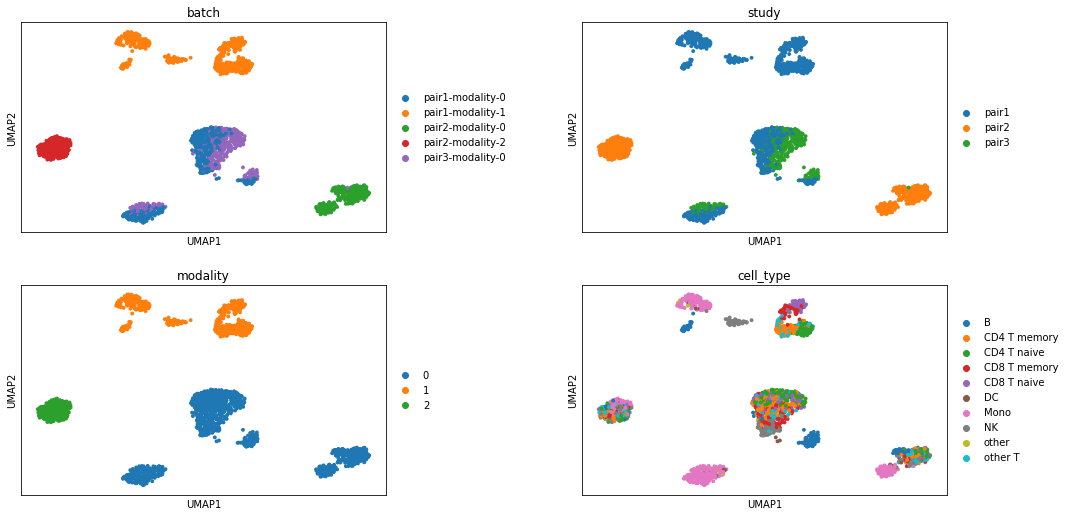

In [30]:
sc.pl.umap(hs, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

... storing 'study' as categorical
... storing 'cell_type' as categorical


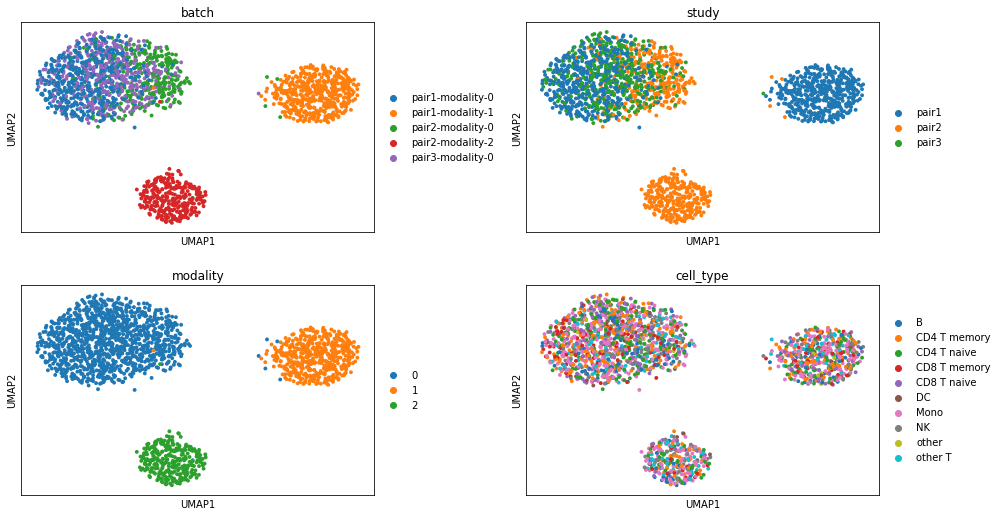

In [31]:
sc.pl.umap(corrected, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.3)

... storing 'study' as categorical
... storing 'cell_type' as categorical


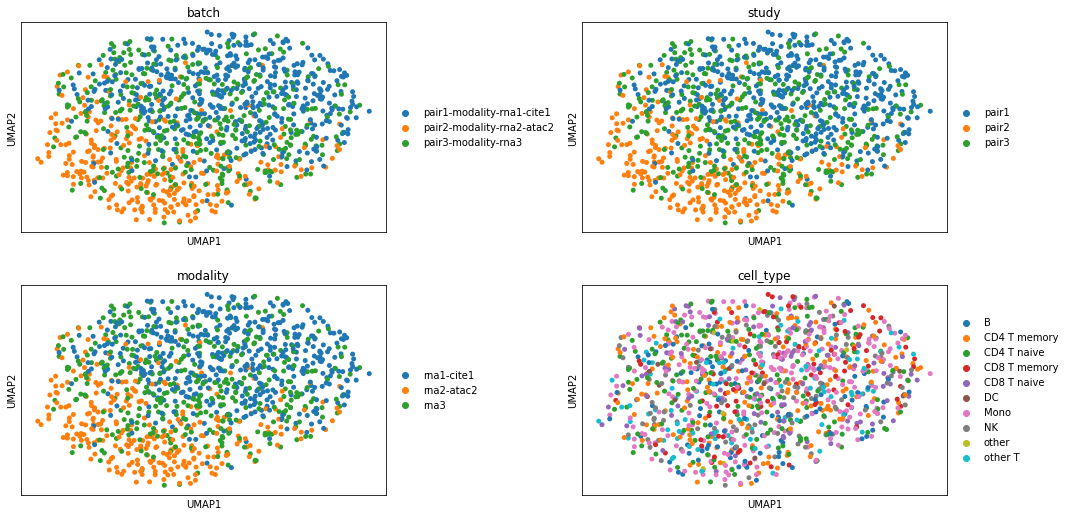

In [32]:
sc.pl.umap(latent, color=['batch', 'study', 'modality', 'cell_type'], ncols=2, wspace=0.4)

... storing 'study' as categorical
... storing 'cell_type' as categorical


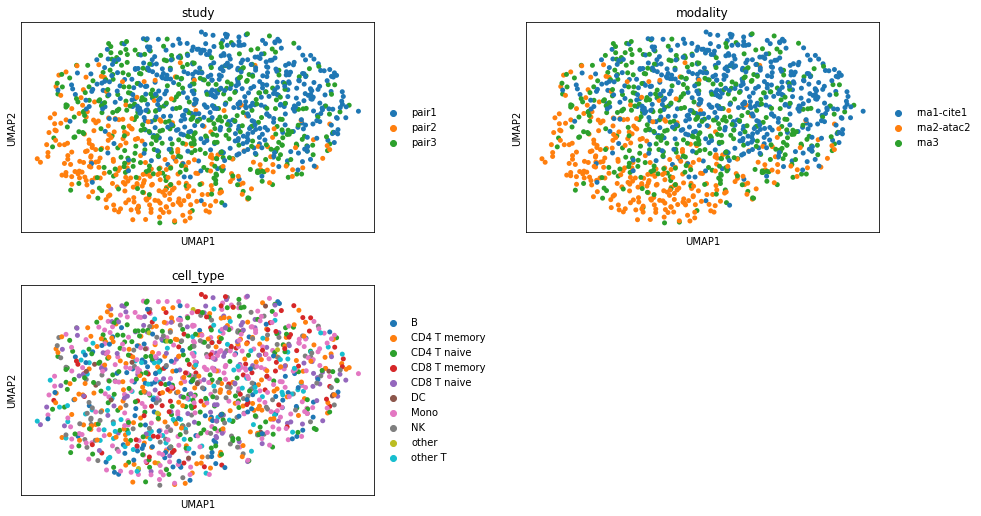

In [33]:
sc.pl.umap(integrated, color=['study', 'modality', 'cell_type'], ncols=2, wspace=0.3)

# impute

In [61]:
protein_pred = model.impute(
        adatas = [[adata3], []],
        names = [['rna3'], []],
        pair_groups = [['pair3'], []],
        target_modality = 1,
        batch_labels = [[2], []],
        target_pair = None,
        layers=[['count'], []],
        batch_size=64,
)

In [35]:
protein_pred.obsm['predicted_protein'] = protein_pred.X

In [36]:
protein_corrs = pd.DataFrame()
for i, protein in enumerate(cite3.var_names):
    value = np.round(pearsonr(protein_pred.obsm['predicted_protein'][:, i], cite3.obsm['true_protein'][:, i])[0], 3)
    protein_corrs = protein_corrs.append({'protein': protein, 'correlation': value}, ignore_index=True)
    
protein_corrs = protein_corrs.append({'protein': 'mean', 'correlation': protein_corrs['correlation'].mean().round(3)}, ignore_index=True)
protein_corrs = protein_corrs.set_index('protein')
protein_corrs

NameError: name 'pd' is not defined

In [302]:
#protein_corrs.to_csv('test.csv')